In [1]:
!export LD_LIBRARY_PATH=/opt/conda/lib
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir
!export PATH=/usr/local/cuda-11.7/bin:${PATH}

In [ ]:
import logging
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import random
from tqdm import tqdm
import pandas as pd
from scipy.stats import uniform, norm
import emcee
from multiprocessing import Pool
import time

import h5py
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Conv1D,Flatten,Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass
from sklearn.utils import shuffle
AUTOTUNE = tf.data.AUTOTUNE
from sklearn.preprocessing import StandardScaler
import tqdm
import gc
import wandb
os.environ['PATH']=os.environ['PATH']+':/usr/local/cuda/bin'
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir'

In [3]:
best_style = {
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (10.0, 10.0),
    "font.size": 26,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
}
plt.style.use(best_style)
cols = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
#set cols as the matplotlib default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cols)

In [4]:
# The test data for population analysis by fixing w=-0.8

data_path = '/deepskieslab/stronglensing/hsbi/datasets/'
image_dir = 'w0_8param_fixzv_test_fixw0-08_3000'
column_name = "w0-g"
fig_title = 'w0'

str_true_w = '-08' 
true_w = -0.8 # Dark energy equation-of-state parameter 
xlim_min = -0.9
xlim_max = -0.7

In [ ]:
# Load the trained model 

model = tf.keras.models.load_model("working_model_1M-2-034_seed38_v2.keras")

In [6]:
# Read the images and metadata and pre-process the data

images_test = np.load(data_path+image_dir+'/CONFIGURATION_1_images.npy', allow_pickle=True)
metadata_test = pd.read_csv(data_path+image_dir+'/CONFIGURATION_1_metadata.csv')


fixed_images_test = np.einsum('lkij->lijk',images_test)
fixed_true_theta_test = metadata_test[column_name].to_numpy()

#normalize image each image by the sum of all pixels, make it such that the sum of all pixels is 1024
fixed_images_test = 1024*(fixed_images_test/np.sum(fixed_images_test, axis=(1,2), keepdims=True))

#manually standardize the images and theta
means_image = 0.0
std_image = 1.0

mean_theta = 0.0
std_theta = 1.0

fixed_images_test = fixed_images_test.reshape(fixed_images_test.shape[0], -1)
fixed_images_test = (fixed_images_test - means_image) / std_image
fixed_images_test = fixed_images_test.reshape(fixed_images_test.shape[0], 32, 32, 1)

fixed_theta_test = (fixed_true_theta_test - mean_theta)/std_theta

### Calculate the Analytical Posterior 

The analytical equation to calculate the posterior is given by

\begin{equation}
\begin{split}
    p(w|\{x\}) &= \frac{p(w)~\prod_{i}r(x_i|w)}{\int dw^{\prime}~ p(w^{\prime})~\prod_{i}r(x_{i}|w^{\prime})},\\
        &= p(w)~\left( \int dw^{\prime}~p(w^{\prime})~\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)} \right)^{-1}.
\end{split}
\end{equation}

```likelihood_diff``` function calculates $log\ r(x|w^{\prime}) - log\ r(x|w)$  for one image $x$ 

This is same as calculating $\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_likelihood``` function calculates  $\sum_{i} log\ r(x_{i}|w^{\prime}) - log\ r(x_{i}|w)$ for a population of strong lens images $\{x_{i}\}$

This is same as calculating $\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_posterior``` calculates the sum of posterior for all the theta ($w$) values and gives the inverse of the sum as shown in the equation

In [ ]:
import numba as nb

@nb.jit
def get_logr_distribution(model, images, sample_theta):
    '''
    Function to predict the log likelihood-to-evidence ratio (logr) of the test data

    Input:
    model: The trained model 
    images: test images
    sample_theta: a list of theta values to compute logr for
    '''
    output_probs = []
    for image in images:
        test_image_array = np.concatenate([image[np.newaxis, :]]*len(sample_theta), axis=0)
        output = model.predict([test_image_array, sample_theta], verbose=0).flatten()
        output_probs.append(output)
    return np.array(output_probs)

class Posterior:
    def __init__(self, lnr, thetas):
        self.lnr = lnr
        self.thetas = thetas

    def likelihood_diff(self, image_index):
        # exp_diff_lnr = np.empty((len(self.thetas), len(self.thetas)))
        diff_lnr_list = np.empty((len(self.thetas), len(self.thetas)))
        for i in range(len(self.thetas)):
            diff_lnr = self.lnr[image_index, i] - self.lnr[image_index]
            # exp_diff_lnr[i] = np.exp(diff_lnr)
            diff_lnr_list[i] = diff_lnr
        # return exp_diff_lnr
        return diff_lnr_list

    def get_joint_likelihood(self, n_images):
        likelihood = np.empty((n_images, len(self.thetas), len(self.thetas)))
        for i in range(n_images):
            likelihood[i] = self.likelihood_diff(i)
        # joint_likelihood = np.prod(likelihood, axis=0)
        joint_likelihood = np.sum(likelihood, axis=0)
        joint_likelihood = np.exp(joint_likelihood)
        return joint_likelihood
    
    def get_joint_posterior(self, n_images):
        joint_likelihood = self.get_joint_likelihood(n_images)
        joint_posterior = 1. / np.sum(joint_likelihood, axis=0)
        return joint_posterior
    
def get_joint_posterior_probability(lnr, thetas, n_images):
    '''
    Function to sample from the posterior probability distribution.

    Output:
    The posterior probability, mean and standard deviation
    '''
    posterior = Posterior(lnr, thetas)
    joint_posterior = posterior.get_joint_posterior(n_images)
    sampled_values = np.random.choice(thetas, size=1000, p=joint_posterior)
    weighted_mean = np.mean(sampled_values)
    weighted_std_dev = np.std(sampled_values)
    # weighted_mean = np.sum(thetas * joint_posterior) / np.sum(joint_posterior)
    # weighted_std_dev = np.sqrt(np.sum(joint_posterior * (thetas - weighted_mean)**2) / np.sum(joint_posterior))
    return joint_posterior, weighted_mean, weighted_std_dev


### Calculate MCMC posterior

In [8]:
def get_logr_mcmc(model, images, sample_theta, mean_theta, std_theta):
    ''''
    Function to predict the log likelihood-to-evidence ratio (logr) of all the test data at a time

    Input:
    model: The trained model 
    images: test images
    sample_theta: a list of theta values to compute logr for

    Output:
    log r 
    '''
    sample_theta = (sample_theta - mean_theta)/std_theta
    theta_array = np.array([sample_theta]*images.shape[0])
    output = model.predict([images, theta_array], verbose=0).flatten()
    return output

def log_prior(theta, theta_low=-1.5, theta_high=-0.5):
    """
    prior for w
    """
    if theta_low < theta < theta_high:
        return 0.0
    return -np.inf

def log_likelihood(theta_, data, theta_low, theta_high, model, mean_theta, std_theta):
    """
    Calculate the log likelihood + log prior
    """
    theta = theta_[0]
    lp = log_prior(theta, theta_low, theta_high)
    if not np.isfinite(lp):
        return -np.inf
    logr_array = get_logr_mcmc(model, data, theta, mean_theta, std_theta)
    ll = np.sum(logr_array)
    return ll+lp

def get_posterior_mcmc(data, theta_low, theta_high, model, walkers=10, nsteps=10000, initial_w = -1.0, mean_theta=-1.0007, std_theta=0.288409, multithread=False):
    """
    MCMC sampling

    Output:
    Sampler and Samples
    """
    pos = np.array([initial_w])+ np.array([initial_w])*1e-3* np.random.randn(walkers, 1)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(data, theta_low, theta_high, model,  mean_theta, std_theta))
    
    if multithread:
        with Pool(10) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(data, theta_low, theta_high, model, mean_theta, std_theta), pool=pool)
            print("Running first burn-in...")
            pos, lp, _ = sampler.run_mcmc(pos, 100, progress=True)
            print('Max lp @',pos[np.argmax(lp)])

            print("Running second burn-in...")
            pos =pos[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
            sampler.reset()
            pos, lp, _ = sampler.run_mcmc(pos, 500,progress=True)
            print('Max lp @',pos[np.argmax(lp)])

            print("Running production...")
            pos = pos[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
            sampler.reset()
            pos, lp, _ = sampler.run_mcmc(pos, nsteps,progress=True)
            print('Max lp @',pos[np.argmax(lp)])  

    else:
        print("Running first burn-in...")
        pos, lp, _ = sampler.run_mcmc(pos, 100, progress=True)
        print('Max lp @',pos[np.argmax(lp)])

        print("Running second burn-in...")
        pos =pos[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
        sampler.reset()
        pos, lp, _ = sampler.run_mcmc(pos, 500,progress=True)
        print('Max lp @',pos[np.argmax(lp)])

        print("Running production...")
        pos = pos[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)
        sampler.reset()
        pos, lp, _ = sampler.run_mcmc(pos, nsteps,progress=True)
        print('Max lp @',pos[np.argmax(lp)])


    samples = sampler.get_chain(discard=int(nsteps/4), flat=False)
    print(samples.shape)

    flat_samples = sampler.get_chain(discard=int(nsteps/4), flat=True)
    print(flat_samples.shape)

    return sampler, samples, flat_samples
    return sampler, samples, flat_samples

In [ ]:
num_images = [5, 100, 500, 1000, 2000, 3000]
start_time=time.time()
for n in num_images:
    sampler, samples, flat_samples = get_posterior_mcmc(fixed_images_test[0:n], -1.5, -0.5, model, walkers=5, nsteps=1000, 
                             initial_w = -1.0, mean_theta=0.0, std_theta=1.0, multithread=False)
    end_time=time.time()
    print('Time taken for ', n, ' images: ', end_time-start_time)
    start_time = end_time
    #save the mcmc sampler
    np.savez('mcmc_posterior'+str_true_w+'_'+str(n)+'.npz', sampler=sampler, samples=samples, flat_samples=flat_samples)
    del sampler, samples, flat_samples

In [10]:
def read_mcmc_samples(filename):
    file = np.load(filename)
    # sampler = file['sampler']
    samples = file['samples']
    flat_samples = file['flat_samples']
    mean_samples = np.mean(flat_samples, axis=0)
    std_samples = np.std(flat_samples, axis=0)
    return samples, flat_samples, mean_samples, std_samples

In [12]:
samples1, flat_samples1, mean_samples1, std_samples1 = read_mcmc_samples('mcmc_posterior'+str_true_w+'_'+str(500)+'.npz')
samples2, flat_samples2, mean_samples2, std_samples2 = read_mcmc_samples('mcmc_posterior'+str_true_w+'_'+str(1000)+'.npz')
samples3, flat_samples3, mean_samples3, std_samples3 = read_mcmc_samples('mcmc_posterior'+str_true_w+'_'+str(2000)+'.npz')
samples4, flat_samples4, mean_samples4, std_samples4 = read_mcmc_samples('mcmc_posterior'+str_true_w+'_'+str(3000)+'.npz')

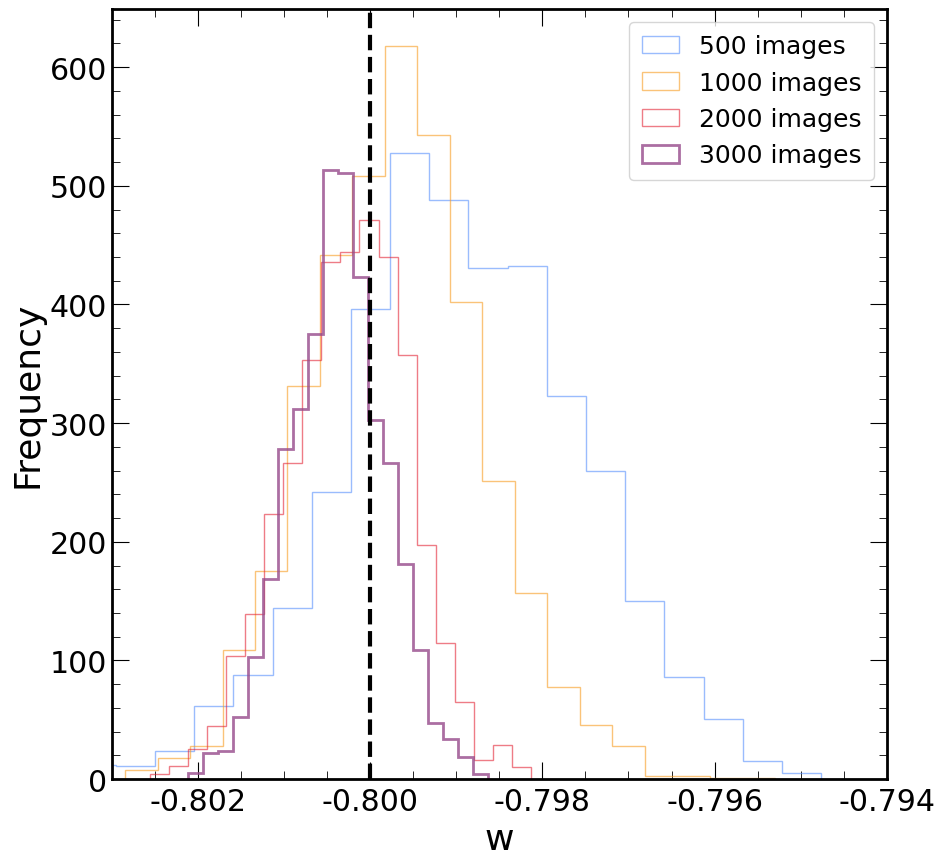

In [15]:
# Plot the Posterior from MCMC sampling

plt.hist(flat_samples1, bins=20, label='500 images', alpha=0.6, histtype='step', lw=1)
plt.hist(flat_samples2, bins=20, label='1000 images', alpha=0.6, histtype='step', lw=1)
plt.hist(flat_samples3, bins=20, label='2000 images', alpha=0.6, histtype='step', lw=1)
plt.hist(flat_samples4, bins=20, label='3000 images', alpha=0.8, histtype='step', lw=2)
plt.axvline(true_w, linestyle='--', color='k', lw=3)
# plt.xlim(xlim_min, xlim_max)
plt.xlim(-0.803, -0.794)
plt.xlabel(r'$w$')
plt.ylabel('Frequency')
plt.legend(fontsize=18)
plt.savefig("MCMC_posterior_w"+str_true_w+'.pdf')
plt.show()

### Analytical Sampling

In [ ]:
sample_theta_unstd = np.linspace(-2.0, -0.4, 2000)
sample_theta = (sample_theta_unstd - mean_theta)/std_theta

lnr_1 = get_logr_distribution(model, fixed_images_test, sample_theta)
np.savez('logr_w'+str_true_w+'_1000_v3.npz', logr=lnr_1)

In [ ]:
import time
num_images = [5, 100, 500, 1000, 2000, 3000]

posteriors_all_list = []
posterior_all_samples = []
start_time = time.time()
for n in num_images:
    posterior, posterior_mean, posterior_std = get_joint_posterior_probability(lnr_1, sample_theta, n)
    end_time = time.time()
    print('Time taken for ', n, ' images: ', end_time-start_time)
    start_time = end_time
    posteriors_all_list.append((posterior_mean, posterior_std))
    posterior_all_samples.append(posterior)

posteriors_all = np.vstack(posteriors_all_list)
posterior_all_samples = np.array(posterior_all_samples)
print('shape of posteriors for ntrials:', np.shape(posterior_all_samples))

np.savez('analytical_posteriors_w'+str_true_w+'_v3.npz', samples=posterior_all_samples, stats=posteriors_all)

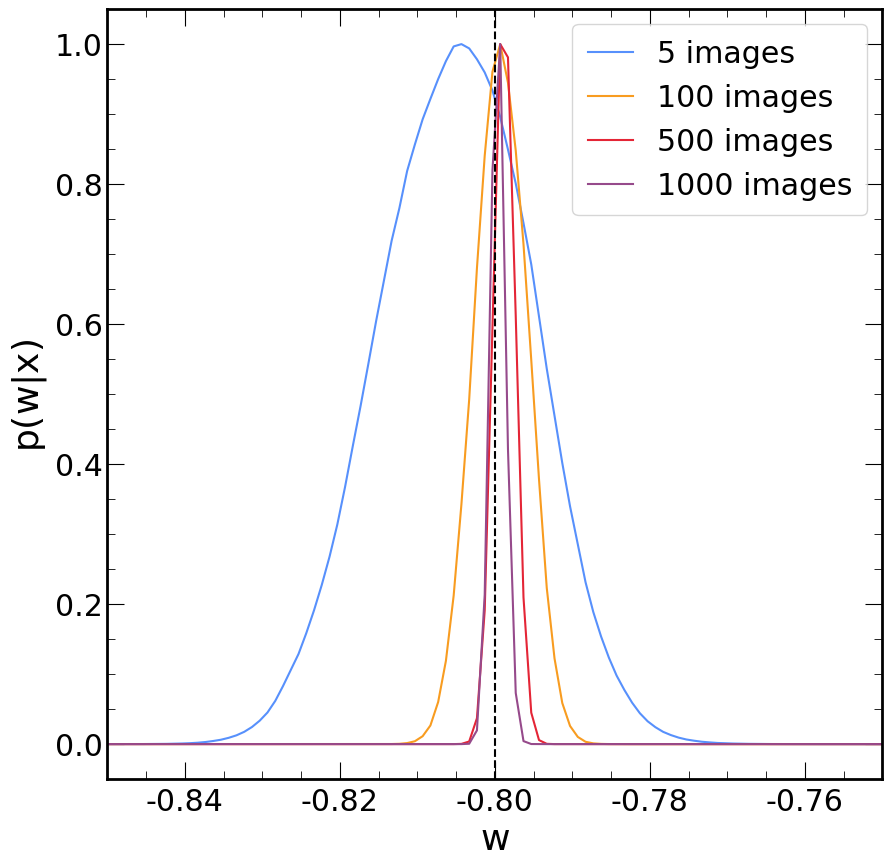

In [16]:
# plot the analytical posterior probability for different number of images

for i, pos in enumerate(posterior_all_samples[2:]):
    plt.plot(sample_theta, pos/np.max(pos), label=str(num_images[i+2])+' images')
plt.axvline(true_w, linestyle='--', color='k')
plt.xlabel(r'$w$')
plt.ylabel(r'$p(w | x)$')
plt.xlim(-0.85, -0.75)
plt.legend()
plt.savefig("Analytical_posterior_w"+str_true_w+'.pdf')
plt.show()

### Plot the mean and std of MCMC and Analytical posteriors 

/tmp/ipykernel_1020/4203446349.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(num_images, np.array([mean_samples1[0], mean_samples2[0], mean_samples3[0], mean_samples4[0]]) ,
/tmp/ipykernel_1020/4203446349.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(np.array([3, 98, 498, 998]), posteriors_all[:,0] , yerr=posteriors_all[:,1],marker='o', fmt='o', label='Analytical')


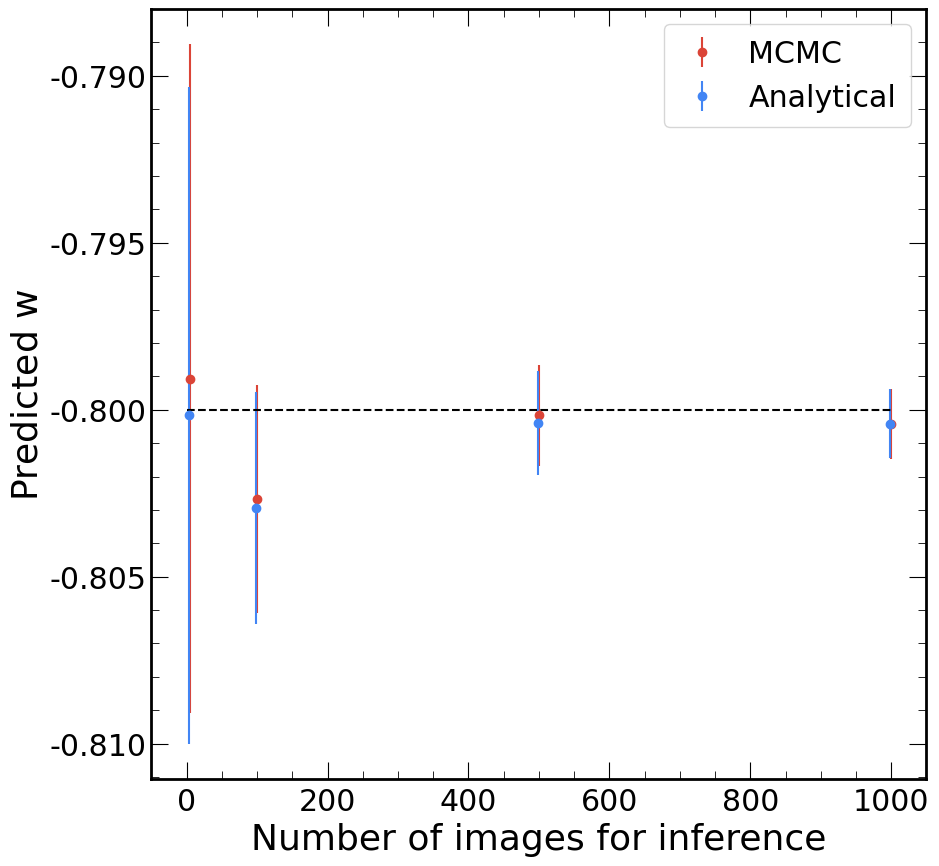

In [17]:

plt.errorbar(num_images, np.array([mean_samples1[0], mean_samples2[0], mean_samples3[0], mean_samples4[0]]) , 
             yerr=np.array([std_samples1[0], std_samples2[0], std_samples3[0], std_samples4[0]]),marker='o', fmt='o', label = 'MCMC')
plt.errorbar(np.array([3, 98, 498, 998]), posteriors_all[:,0] , yerr=posteriors_all[:,1],marker='o', fmt='o', label='Analytical')
plt.hlines(true_w, 0, 1000, ls='--', color='k')
plt.xlabel('Number of images for inference')
plt.ylabel(r'$Predicted\ w$')
plt.legend()
plt.savefig("MCMC_analytical_posterior_w"+str_true_w+".pdf")
plt.show()